# Data API

## Server
The CLIMADA data file server is hosted on https://data.iac.ethz.ch that can be accessed via a REST API at https://climada.ethz.ch.
For REST API details, see the [documentation](https:/climada.ethz.ch/rest/docs).

## Client

For programmatical access to the CLIMADA data API there is a specific REST call wrapper class: `climada.util.client.Client`.

In [2]:
from climada.util.api_client import Client, DataTypeInfo
Client?

In [3]:
client = Client()
client.host, client.chunk_size

('https://climada.ethz.ch', 8192)

The url to the API server and the chunk size for the file download can be configured in 'climada.conf'. Just replace the corresponding default values:

```json
    "data_api": {
        "host": "https://climada.ethz.ch",
        "chunk_size": 8192,
        "cache_db": "{local_data.system}/.downloads.db"
    }
```

The other configuration value affecting the data_api client, `cache_db`, is the path to an SQLite database file, which is keeping track of the files that are successfully downloaded from the api server. Before the Client attempts to download any file from the server, it checks whether the file has been downloaded before and if so, whether the previously downloaded file still looks good (i.e., size and time stamp are as expected). If all of this is the case, the file is simply read from disk without submitting another request.

The main methods of the client are `get_dataset`, `get_datasets` and `download_dataset`. The first two return meta-data about one ore more datasets and the latter downloads all files associated to a dataset.

The signature of `get_dataset` and `get_datasets` are almost identical. Both take `data_type`, `name`, `version`, `properties` and `status` as optional arguments.
The difference is in the default value of the `status` ("active" vs. `None`) and the return type: `get_datasets` returns a list of `DatasetInfo` objects, which may me empty, whereas `get_dataset` returns a single `DatasetInfo` object - or raises an Exception if the arguments provided don't allow a positive identification of the dataset.

In [3]:
client.get_datasets?

Signature:
client.get_datasets(
    data_type=None,
    name=None,
    version=None,
    properties=None,
    status='active',
)
Docstring:
Find all datasets matching the given parameters.

Parameters
----------
data_type : str, optional
    data_type of the dataset, e.g., 'litpop' or 'draught'
name : str, optional
    the name of the dataset
version : str, optional
    the version of the dataset
properties : dict, optional
    search parameters for dataset properties, by default None
status : str, optional
    valid values are 'preliminary', 'active', 'expired', and 'test_dataset',
    by default 'active'

Returns
-------
list of DatasetInfo
File:      c:\users\me\www\climada_python\climada\util\api_client.py
Type:      method


## Metadata

### Unique Identifiers
Any dataset can be identified with **data_type**, **name** and **version**. The combination of the three is unique in the API servers' underlying database.
However, sometimes the name is already enough for identification.
All datasets have a UUID, a universally unique identifier, which is part of their individual url. 
E.g., the uuid of the dataset https://climada.ethz.ch/rest/dataset/b1c76120-4e60-4d8f-99c0-7e1e7b7860ec is "b1c76120-4e60-4d8f-99c0-7e1e7b7860ec".
One can retrieve their meta data by:

In [4]:
client.get_dataset_by_uuid('b1c76120-4e60-4d8f-99c0-7e1e7b7860ec')

DatasetInfo(uuid='b1c76120-4e60-4d8f-99c0-7e1e7b7860ec', data_type=DataTypeInfo(data_type='litpop', data_type_group='exposures', description=None), name='LitPop_assets_pc_150arcsec_SGS', version='v1', status='active', properties={'resolution': '150arcsec', 'exponents': '(3,0)', 'fin_mode': 'pc', 'country_iso3alpha': 'SGS', 'country_name': 'South Georgia and the South Sandwich Islands'}, files=[FileInfo(uuid='b1c76120-4e60-4d8f-99c0-7e1e7b7860ec', url='https://data.iac.ethz.ch/climada/b1c76120-4e60-4d8f-99c0-7e1e7b7860ec/LitPop_assets_pc_150arcsec_SGS.h5', file_name='LitPop_assets_pc_150arcsec_SGS.h5', file_format='hdf5', file_size=1086488, check_sum='md5:9e4ef3c833b68edbc935af2c8c26405a')], doi=None, description='LitPop CLIMADA Exposures by country, at a resolution of 150arcsec. The asset values are measured in produced capital based on nightlights intensity (NASA). ', license='Attribution 4.0 International (CC BY 4.0)', activation_date='2021-08-27 08:17:52.175843+00:00', expiration_da

or by filtering:

In [5]:
client.get_dataset(name='LitPop_assets_pc_150arcsec_SGS', version='v1')  # or client.get_dataset(name='LitPop_assets_pc_150arcsec_SGS') since ther is only 1 version atm.

DatasetInfo(uuid='b1c76120-4e60-4d8f-99c0-7e1e7b7860ec', data_type=DataTypeInfo(data_type='litpop', data_type_group='exposures', description=None), name='LitPop_assets_pc_150arcsec_SGS', version='v1', status='active', properties={'resolution': '150arcsec', 'exponents': '(3,0)', 'fin_mode': 'pc', 'country_iso3alpha': 'SGS', 'country_name': 'South Georgia and the South Sandwich Islands'}, files=[FileInfo(uuid='b1c76120-4e60-4d8f-99c0-7e1e7b7860ec', url='https://data.iac.ethz.ch/climada/b1c76120-4e60-4d8f-99c0-7e1e7b7860ec/LitPop_assets_pc_150arcsec_SGS.h5', file_name='LitPop_assets_pc_150arcsec_SGS.h5', file_format='hdf5', file_size=1086488, check_sum='md5:9e4ef3c833b68edbc935af2c8c26405a')], doi=None, description='LitPop CLIMADA Exposures by country, at a resolution of 150arcsec. The asset values are measured in produced capital based on nightlights intensity (NASA). ', license='Attribution 4.0 International (CC BY 4.0)', activation_date='2021-08-27 08:17:52.175843+00:00', expiration_da

### Data types
A sorted list of all registered data types can be created like this:

In [6]:
import pandas as pd
data_types = client.get_data_types()

dtf = pd.DataFrame(data_types)
dtf.sort_values(['data_type_group', 'data_type'])

,data_type,data_type_group,description
14,disc_rates,disc_rates,None
0,dummy,dummy-group,self explained
3,test-dummy,dummy-group,None
24,entity,entity,None
9,base,exposures,None
20,crop_production,exposures,None
12,earth_engine,exposures,None
1,litpop,exposures,None
27,open_street_map,exposures,None
28,centroids,hazard,None


### Data Set Status
The datasets of climada.ethz.ch may have the following stati:
- **active**: the deault for real life data
- **preliminary**: when the dataset is already uploaded but some information or file is still missing
- **expired**: when a dataset is inactivated again
- **test_dataset**: data sets that are used in unit or integration tests have this status in order to be taken seriously by accident
When collecting a list of datasets with `get_datasets`, the default dataset status will be 'active'. With the argument `status=None` this filter can be turned off.

### DatasetInfo Objects and DataFrames

As stated above `get_dataset` (or `get_dataset_by_uuid`) return a `DatasetInfo` object and `get_datasets` a list thereof.

In [7]:
from climada.util.api_client import DatasetInfo
DatasetInfo?

Init signature:
DatasetInfo(
    uuid: str,
    data_type: climada.util.api_client.DataTypeInfo,
    name: str,
    version: str,
    status: str,
    properties: dict,
    files: list,
    doi: str,
    description: str,
    license: str,
    activation_date: str,
    expiration_date: str,
) -> None
Docstring:      dataset data from CLIMADA data API.
File:           c:\users\me\www\climada_python\climada\util\api_client.py
Type:           type
Subclasses:     


where files is a list of `FileInfo` objects:

In [8]:
from climada.util.api_client import FileInfo
FileInfo?

Init signature:
FileInfo(
    uuid: str,
    url: str,
    file_name: str,
    file_format: str,
    file_size: int,
    check_sum: str,
) -> None
Docstring:      file data from CLIMADA data API.
File:           c:\users\me\www\climada_python\climada\util\api_client.py
Type:           type
Subclasses:     


#### Example

In [9]:
ds = client.get_dataset_by_uuid('b1c76120-4e60-4d8f-99c0-7e1e7b7860ec')
ds.uuid, ds.data_type, ds.name, ds.version, ds.properties

('b1c76120-4e60-4d8f-99c0-7e1e7b7860ec',
 DataTypeInfo(data_type='litpop', data_type_group='exposures', description=None),
 'LitPop_assets_pc_150arcsec_SGS',
 'v1',
 {'resolution': '150arcsec',
  'exponents': '(3,0)',
  'fin_mode': 'pc',
  'country_iso3alpha': 'SGS',
  'country_name': 'South Georgia and the South Sandwich Islands'})

#### Convert into DataFrame
Since `DatasetInfo` is a `@dataclass`, a list of such objects can be easily turned into a `pandas.DataFrame`:

In [10]:
import pandas as pd
pd.DataFrame([ds])

,uuid,data_type,name,version,status,properties,files,doi,description,license,activation_date,expiration_date
0,b1c76120-4e60-4d8f-99c0-7e1e7b7860ec,"{'data_type': 'litpop', 'data_type_group': 'ex...",LitPop_assets_pc_150arcsec_SGS,v1,active,"{'resolution': '150arcsec', 'exponents': '(3,0...",[{'uuid': 'b1c76120-4e60-4d8f-99c0-7e1e7b7860e...,None,"LitPop CLIMADA Exposures by country, at a reso...",Attribution 4.0 International (CC BY 4.0),2021-08-27 08:17:52.175843+00:00,None


In [11]:
litpop_datasets = client.get_datasets(data_type='litpop', properties={'country_name': 'South Georgia and the South Sandwich Islands'})
lpdf = pd.DataFrame(litpop_datasets)
lpdf

,uuid,data_type,name,version,status,properties,files,doi,description,license,activation_date,expiration_date
0,b1c76120-4e60-4d8f-99c0-7e1e7b7860ec,"{'data_type': 'litpop', 'data_type_group': 'ex...",LitPop_assets_pc_150arcsec_SGS,v1,active,"{'resolution': '150arcsec', 'exponents': '(3,0...",[{'uuid': 'b1c76120-4e60-4d8f-99c0-7e1e7b7860e...,None,"LitPop CLIMADA Exposures by country, at a reso...",Attribution 4.0 International (CC BY 4.0),2021-08-27 08:17:52.175843+00:00,None
1,3d516897-5f87-46e6-b673-9e6c00d110ec,"{'data_type': 'litpop', 'data_type_group': 'ex...",LitPop_pop_150arcsec_SGS,v1,active,"{'resolution': '150arcsec', 'exponents': '(0,1...",[{'uuid': '3d516897-5f87-46e6-b673-9e6c00d110e...,None,"LitPop CLIMADA Exposures by country, at a reso...",Attribution 4.0 International (CC BY 4.0),None,None
2,a6864a65-36a2-4701-91bc-81b1355103b5,"{'data_type': 'litpop', 'data_type_group': 'ex...",LitPop_150arcsec_SGS,v1,active,"{'resolution': '150arcsec', 'exponents': '(1,1...",[{'uuid': 'a6864a65-36a2-4701-91bc-81b1355103b...,None,"LitPop CLIMADA Exposures by country, at a reso...",Attribution 4.0 International (CC BY 4.0),None,None


#### Expand properties and data types into DataFrames
The columns "properties" and "data_type" are dictionaries and thus hard to read in jupyter or spyder. Expanding them to DataFrames can be done in this way:

In [12]:
lp_data_type_df = pd.DataFrame([pd.Series(dt) for dt in lpdf.data_type])
lp_data_type_df.head()

,data_type,data_type_group,description
0,litpop,exposures,None
1,litpop,exposures,None
2,litpop,exposures,None


In [13]:
lp_properties_df = pd.DataFrame([pd.Series(p) for p in lpdf.properties])
lp_properties_df

,resolution,exponents,fin_mode,country_iso3alpha,country_name
0,150arcsec,"(3,0)",pc,SGS,South Georgia and the South Sandwich Islands
1,150arcsec,"(0,1)",pc,SGS,South Georgia and the South Sandwich Islands
2,150arcsec,"(1,1)",gdp,SGS,South Georgia and the South Sandwich Islands


The resulting DataFrame can be simply joined with the original dataset DataFrame.

#### Expand files into a DataFrame
The column "files" and is a list of `FileInfo` objects and also hard to read in jupyter or spyder. Expanding them to a DataFrame can be done in this way:

In [14]:
lp_files_df = pd.DataFrame([fileinfo for dataset in litpop_datasets for fileinfo in dataset.files])
lp_files_df

,uuid,url,file_name,file_format,file_size,check_sum
0,b1c76120-4e60-4d8f-99c0-7e1e7b7860ec,https://data.iac.ethz.ch/climada/b1c76120-4e60...,LitPop_assets_pc_150arcsec_SGS.h5,hdf5,1086488,md5:9e4ef3c833b68edbc935af2c8c26405a
1,3d516897-5f87-46e6-b673-9e6c00d110ec,https://data.iac.ethz.ch/climada/3d516897-5f87...,LitPop_pop_150arcsec_SGS.h5,hdf5,1086488,md5:6b2765e4d73ba8430efbc68e0abd6abc
2,a6864a65-36a2-4701-91bc-81b1355103b5,https://data.iac.ethz.ch/climada/a6864a65-36a2...,LitPop_150arcsec_SGS.h5,hdf5,1086488,md5:1114b81d93d7b0b7632669281b3eea71


The resulting DataFrame does not have the same shape as the dataset DataFrame, since each dataset can contain multiple files. Therefore a simple join won't work. But the DataFrame can be merged by 'uuid':

In [15]:
lp_files_df.merge(lpdf.join(lp_properties_df), on='uuid').loc[:,['uuid', 'name', 'country_name', 'fin_mode', 'exponents', 'file_size', 'file_name']]

,uuid,name,country_name,fin_mode,exponents,file_size,file_name
0,b1c76120-4e60-4d8f-99c0-7e1e7b7860ec,LitPop_assets_pc_150arcsec_SGS,South Georgia and the South Sandwich Islands,pc,"(3,0)",1086488,LitPop_assets_pc_150arcsec_SGS.h5
1,3d516897-5f87-46e6-b673-9e6c00d110ec,LitPop_pop_150arcsec_SGS,South Georgia and the South Sandwich Islands,pc,"(0,1)",1086488,LitPop_pop_150arcsec_SGS.h5
2,a6864a65-36a2-4701-91bc-81b1355103b5,LitPop_150arcsec_SGS,South Georgia and the South Sandwich Islands,gdp,"(1,1)",1086488,LitPop_150arcsec_SGS.h5


## Download

There are two methods to download files through the API: `download_dataset` which takes a `DatasetInfo` as argument and downloads all files of the dataset at once and `download_file` which takes a single `FileInfo` object as argument.

In [16]:
client.download_dataset?

Signature:
client.download_dataset(
    dataset,
    target_dir=WindowsPath('C:/Users/me/climada/data'),
    organize_path=True,
    check=<function checksize at 0x0000027F7BA874C0>,
)
Docstring:
Download all files from a given dataset to a given directory.

Parameters
----------
dataset : DatasetInfo
    the dataset
target_dir : Path, optional
    target directory for download, by default `climada.util.constants.SYSTEM_DIR`
organize_path: bool, optional
    if set to True the files will end up in subdirectories of target_dir:
    [target_dir]/[data_type_group]/[data_type]/[name]/[version]
    by default True
check : function, optional
    how to check download success for each file, by default Download.checksize

Returns
-------
download_dir : Path
    the path to the directory containing the downloaded files,
    will be created if organize_path is True
downloaded_files : list of Path
    the downloaded files themselves

Raises
------
Exception
    when one of the files cannot be dow

In [17]:
client.download_file?

Signature:
client.download_file(
    local_path,
    fileinfo,
    check=<function checksize at 0x0000027F7BA874C0>,
    retries=3,
)
Docstring:
Download a file if it is not already present at the target destination.

Parameters
----------
local_path : Path
    target destination,
    if it is a directory the original filename (fileinfo.filen_name) is kept
fileinfo : FileInfo
    file object as retrieved from the data api
check : function, optional
    how to check download success, by default checksize
retries : int, optional
    how many times one should retry in case of failure, by default 3

Returns
-------
Path
    the path to the downloaded file

Raises
------
Exception
    when number of retries was exceeded or when a download is already running
File:      c:\users\me\www\climada_python\climada\util\api_client.py
Type:      method


#### Cache
Both methods avoid superfluous downloads by keeping track of all downloads in a sqlite db file. The client will make sure that the same file is never downloaded to the same target twice.

#### Examples

In [18]:
download_dir, ds_files = client.download_dataset(ds)
ds_files[0], ds_files[0].is_file()

(WindowsPath('C:/Users/me/climada/data/exposures/litpop/LitPop_assets_pc_150arcsec_SGS/v1/LitPop_assets_pc_150arcsec_SGS.h5'),
 True)

In [19]:
from pathlib import Path
ds_file = client.download_file(Path('.'), ds.files[0])
ds_file, ds_file.is_file()

(WindowsPath('LitPop_assets_pc_150arcsec_SGS.h5'), True)

### Wrapper functions


The following wrapper functions allow to directly open CLIMADA exposures or hazards from datasets in the API.

In [3]:
client = Client()
river_flood_CHE = client.get_hazard()

The following data types are available: river_flood, tropical_cyclone, storm_europe. Which one do you want to get?river_flood
The following geographical_scale are available: country, global. Which one would you like to get?country
The following year_range are available: 2010_2030, 2030_2050, 2050_2070, 2070_2090. Which one would you like to get?2010_2030
The following rcp are available: rcp26, rcp85. Which one would you like to get?rcp26
The following country_name are available: Afghanistan, Albania, Algeria, American Samoa, Andorra, Angola, Anguilla, Antigua and Barbuda, Argentina, Armenia, Aruba, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, Belize, Benin, Bermuda, Bhutan, Bolivia, Plurinational State of, Bosnia and Herzegovina, Botswana, Brazil, British Indian Ocean Territory, Brunei Darussalam, Bulgaria, Burkina Faso, Burundi, Cabo Verde, Cambodia, Cameroon, Canada, Cayman Islands, Central African Republic, Chad, Chile, China, Colombia, C

<GeoAxesSubplot:title={'center':'RF max intensity at each point'}>

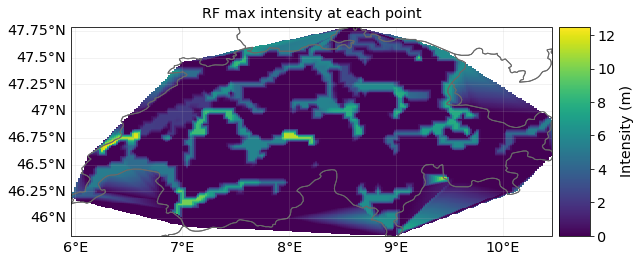

In [8]:
river_flood_CHE.plot_intensity(0)

You may also provide several countries which will be combined into one file:

In [4]:
client = Client()
TC = client.get_hazard()

The following data types are available: river_flood, tropical_cyclone, storm_europe. Which one do you want to get?tropical_cyclone
The following geographical_scale are available: country, genesis_basin, global. Which one would you like to get?country
The following n_tracks are available: 10, 50. Which one would you like to get?10
The following year are available: 2020, 2040, 2060, 2080. Which one would you like to get?2020
The following country_name are available: Afghanistan, Albania, Algeria, Andorra, Angola, Anguilla, Antigua and Barbuda, Argentina, Aruba, Australia, Austria, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, Belize, Benin, Bermuda, Bhutan, Bosnia and Herzegovina, Botswana, Brazil, British Indian Ocean Territory, Brunei Darussalam, Bulgaria, Burkina Faso, Burundi, Cabo Verde, Cambodia, Cameroon, Canada, Cayman Islands, Central African Republic, Chad, China, Colombia, Comoros, Congo, Congo, Democratic Republic of the, Costa Rica, Croatia, Cuba, Curaçao, Czechi

<GeoAxesSubplot:title={'center':'TC max intensity at each point'}>

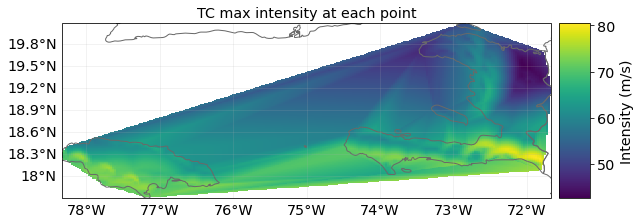

In [5]:
TC.plot_intensity(0)